In [4]:
import os
import findspark
#os.environ['SPARK_HOME'] = '/opt/apache-spark'
os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/2.2.0/libexec/'
findspark.init()
from pyspark import SQLContext, SparkContext
from pyspark.sql import functions as F
import json
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Applications/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Creation of a Spark contest.

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Introduction : manipulating and exploring the data

For our project we chose to work on the Amazon reviews data set, available here: http://jmcauley.ucsd.edu/data/amazon/. Some subsets are available and they allow us to have a sneak peak on the review collection before manipulating larger datasets. We will begin to do some classification and observations of the data we have, according to the available features (identificator of the reviewer, grades given, identifier of the products or related ones...)

First we need to load the data of subsets from json files. We chose the subsets containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food". We will use this dataset on our local machine to qualitatively manipulate the data. 

In [3]:
review_df = sqlContext.read.json("reviews_auto_baby_grocery.json")

We get the count of review of distinc article per reviewer and filter those that have less than 5 review.

In [4]:
review_df_count = review_df.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [5]:
review_df_filtered = review_df.join(review_df_count, on='reviewerID').drop('count')

We compute the average grade for each reviewer.

In [6]:
average_score = review_df_filtered.groupBy("reviewerID").avg("overall").select("avg(overall)")

In [7]:
average_std_score = review_df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
#average_std_score.cache().count()

109193

Here are some statistic concerning the average grade for each reviewer.

The first row contains the total number of reviewer considered.

The second row contains the mean of the reviewers' averages grades (left) and the standard deviation of said mean (right).

The third row contains the mean of the reviewers' standard deviations (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's lower grades (left) and the standard deviation of said mean (right).

The fourth row contains the mean of the reviewer's higher grades (left) and the standard deviation of said mean (right).

In [8]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



We then plot the average grade for each reviewer through histograms, with the grade on the x-axis and the number of reviewers who have such mean ranking on the y-axis.

NameError: name 'hist' is not defined

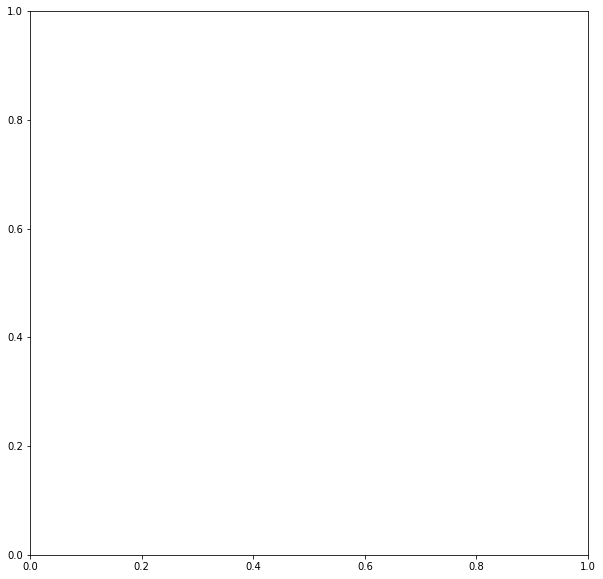

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("mean"));
plt.title("average grade given by reviewer")

It can be noted that reviewers tend to give high ratings.

We then plot the average standard deviation for each reviewer through histograms, with the grade on the x-axis and the number of reviewers who have such average standard deviation on the y-axis.

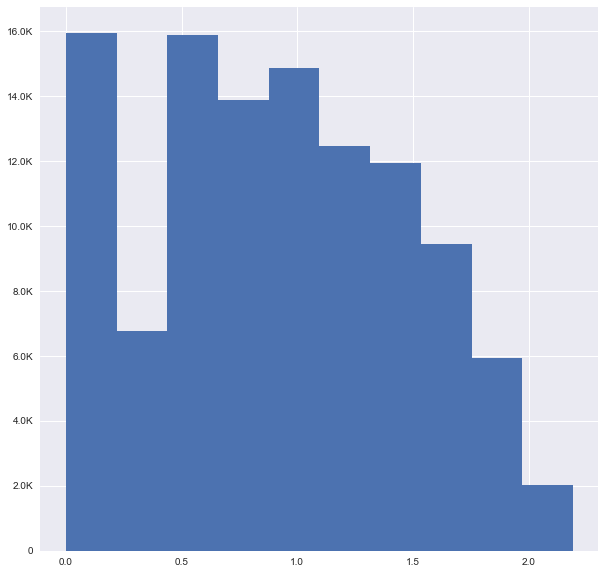

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("std"));
plt.title("standard deviation in the grades given for each reviewer")

It can be noted that the majority of reviewers tend to have either a very small standard deviation (0-0.25) or a standard deviation between 0.5 and 1.5. The number of people with an higher standard deviation are sensibily less.

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 14.72% of reviewer with std < 0.25


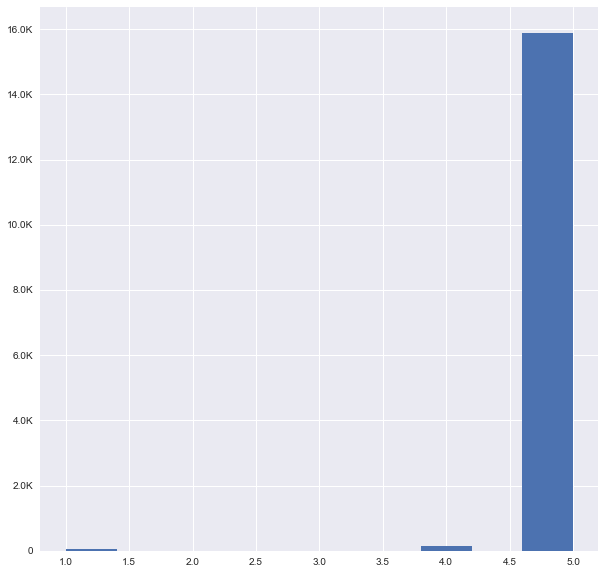

In [11]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));
plt.title("number or grades given by reviewer with the lower standard deviation")

It can be noted that people with a small standard deviation, i.e. people who tend to always give the same rating, tend to give only very high rating (>4.5).

Here we load the product's metadata.

In [12]:
meta_df = sqlContext.read.json("meta_auto_baby_grocery.json")

Compute the total number of products.

In [13]:
total_products = meta_df.count()
total_products

574167

We filter the salesRank to have only ranked products. There is two possiblity, either the salesRank is completely none, either the categories are all None. we take care of both cases.

In [14]:
def drop_none(salesRank):
    count = 0
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return count == 1
drop_none = udf(drop_none, BooleanType())
filtered_meta_df = meta_df.dropna(subset=['salesRank']).withColumn("toKeep", drop_none("salesRank"))
filtered_meta_df = filtered_meta_df.filter(filtered_meta_df['toKeep'])
filtered_meta_df = filtered_meta_df.drop('toKeep')

Compute the ratio between ranked and total products.

In [15]:
ranked_products = filtered_meta_df.count()
ranked_products
ratio = ranked_products/total_products
print("ranked_products: " + str(ranked_products) + " total products: " + str(total_products) + " ratio: " + str(ratio))

ranked_products: 159803 total products: 574167 ratio: 0.278321463964317


We can notice that in this restricted dataset less than one third of the products is ranked, a fact that makes our rank-based analysis less representative. 

We now check that there is exactly one category that has a sales rank.

In [16]:
def check_exactly_one(salesRank):
    count = 0 
    for category, rank in salesRank.asDict().items():
        if rank != None:
            count += 1
    return count == 1
check_exactly_one = udf(check_exactly_one, BooleanType())
only_one = filtered_meta_df.withColumn("unique_rank", check_exactly_one("salesRank"))
print("There is %.d article with not exactly one category for a rank"%only_one.filter(~only_one["unique_rank"]).count())

There is 0 article with not exactly one category for a rank


Finally, we make the struct flatter, by having a salesRank that has two elements, category and rank.

In [17]:
def notNone(salesRank):
    for category, rank in salesRank.asDict().items():
        if rank != None:
            return (category, rank)
#udf_notNone = udf(notNone, StructType([StructField("category", StringType()), StructField("rank", IntegerType())]))
#filtered_meta_df = filtered_meta_df.withColumn("salesRank", udf_notNone("salesRank"))

Here we obtain the names of the ranking categories.

In [18]:
rank_categories = filtered_meta_df.head().salesRank.asDict().keys()

To sum up, in this introduction we have made a sneak peak of the Amazon reviews dataset, and we have been able to see the various possibilities offered by the manipulation of the available features. Now we will turn to some questions we set up in the README file of the project.

# Question 4 : influence of the "also bought..." feature

We'll begin by focusing on the "bought together" feature instead of the "also bought" feature right away, because we finally noted that the former is more relevant to the question. Moreover it is handled in a better scale : "also bought" tends to be a very long list of products while "bought together" is usually much shorter and easier to analyze.

In order to answer this question, it is possible to use the following approach :
1. Find the best ranked products for each category.
2. look at the rank of the products that were bought together with them.
3. draw  qualitative conclusions.

First we select the interesting columns of the metadata dataframe, flattening the hierarchical datastructure in the process.

In [19]:
filtered_meta_df = filtered_meta_df.select('salesRank.*', "asin", "related.*")

Then we define a function that allows to find in which category a product has been ranked.

In [20]:
def find_nonnull_category(product):
    for category in rank_categories:
        ranking = product[category]
        if ranking != None:
            return category, ranking 

In [21]:
for category in rank_categories:
    category_df = filtered_meta_df.select(category, "asin", "bought_together").dropna(how='any').sort(category, ascending = False)
    best_products = category_df.take(5)
    for index, best_product in enumerate(best_products):
        productid = best_product.asin
        bought_together = best_product.bought_together
        rank = best_product[category]
        for associated_id in bought_together:
            associated_product = filtered_meta_df.filter(filtered_meta_df.asin == associated_id).first()
            if associated_product != None:
                associated_category, associated_rank = find_nonnull_category(associated_product)
                print("The product " + str(productid) + " ranked " + str(rank) + " in category " + category + " was bought together with the product " + str(associated_id) + " ranked " + str(associated_rank) + " in category " + associated_category)

The product B000BOCATE ranked 344278 in category Home Improvement was bought together with the product B000BOB4VO ranked 202096 in category Kitchen & Dining
The product B005AWYHQG ranked 331032 in category Industrial & Scientific was bought together with the product B005AX2NDE ranked 18295 in category Industrial & Scientific
The product B0083COONQ ranked 244540 in category Industrial & Scientific was bought together with the product B0083COP1M ranked 15092 in category Industrial & Scientific
The product B003L9L43Y ranked 516679 in category Cell Phones & Accessories was bought together with the product B0000GIZTC ranked 175712 in category Grocery & Gourmet Food
The product B000O9IXSI ranked 189377 in category Cell Phones & Accessories was bought together with the product B000LTM29M ranked 452 in category Grocery & Gourmet Food
The product B000O9IXSI ranked 189377 in category Cell Phones & Accessories was bought together with the product B000LTIDR2 ranked 449 in category Grocery & Gourme

It can be noted that products with very different rankings were bought together.
This means that question 4 might indeed make sense, there might be "good" products that improve the sales of "bad" products. As of now "good" means "popular" and bad means "unpopular", the definition might change when we delve even further into the data.

# Question 5 : #rank/#review ratio

The approach for question 5 is the following:
1. For each rank category, take the 5 best ranked products
2. look in the review table and see how many reviews were made for each product
3. Print the values and try to qualitatevely interpret. 

Here we apply the described pipeline.

In [22]:
for category in rank_categories:
    category_df = filtered_meta_df.select(category, "asin").dropna().sort(category, ascending = False)
    best_products = category_df.take(5)
    for index, best_product in enumerate(best_products):
        productid = best_product.asin
        rank = best_product[category]
        number_reviews = review_df.filter(review_df.asin == productid).count()
        print("There are " + str(number_reviews) + " reviews for the product ranked " + str(rank) + " in the category " + category)

There are 1 reviews for the product ranked 667889 in the category Home Improvement
There are 1 reviews for the product ranked 567974 in the category Home Improvement
There are 1 reviews for the product ranked 556164 in the category Home Improvement
There are 1 reviews for the product ranked 549535 in the category Home Improvement
There are 1 reviews for the product ranked 522108 in the category Home Improvement
There are 1 reviews for the product ranked 1363090 in the category Music
There are 3 reviews for the product ranked 1104466 in the category Music
There are 1 reviews for the product ranked 1084118 in the category Music
There are 3 reviews for the product ranked 879635 in the category Music
There are 2 reviews for the product ranked 807523 in the category Music
There are 1 reviews for the product ranked 934956 in the category Shoes
There are 4 reviews for the product ranked 788552 in the category Shoes
There are 1 reviews for the product ranked 750943 in the category Shoes
There 

There are 1 reviews for the product ranked 680019 in the category Arts, Crafts & Sewing
There are 2 reviews for the product ranked 685420 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 672020 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671644 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671389 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 671177 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 202764 in the category Musical Instruments
There are 0 reviews for the product ranked 164459 in the category Musical Instruments
There are 0 reviews for the product ranked 150258 in the category Musical Instruments
There are 2 reviews for the product ranked 124981 in the category Musical Instruments
There are 1 reviews for the product ranked 104918 in the category Musical Instruments
There are 1 reviews for the product ranked 1186

It doesn't seem to be any correlation between the number of reviews associated to a product and its sales ranking according to these results, which doesn't give any hint about a linear relationship between number of reviews and sales.

# Question 6 : product categorization

I start by filtering the metadata to drop the uncategorized products.

In [23]:
filtered_meta_df = meta_df.dropna(subset=['categories'])
filtered_meta_df.count()

512526

Then I proceed to analyze the products.
The approach is the following:
1. I create a dictionary to map each category to the number of reviews written for that category.
2. for each product, I extract the categories it is part of.
3. I compute the number of reviews for that product and I update the values associated to the product categories in the dictionary.

I limit the analysis to 10 products on my local machine due to the heavy computational cost, however on the cluster we'll analyze all of them.

In [24]:
category_dict = {}
#NOTE: the commented line is the one to be used in the cluster.
#for product in filtered_meta_df.collect():
for product in filtered_meta_df.take(10):
    productid = product.asin
    categories = product.categories[0]
    for category in categories:
        number_reviews = review_df.filter(review_df.asin == productid).count()
        old_value = category_dict.get(category, 0)
        category_dict[category] = old_value + number_reviews

print(str(category_dict))

{'Antitheft': 2, 'Grips': 1, 'Lighting Assemblies & Accessories': 1, 'Power Window Motors': 1, 'Hand Controls': 1, 'Bulbs': 6, 'Window Regulators & Motors': 1, 'Paint, Body & Trim': 5, 'Paints & Primers': 5, 'Handlebars & Components': 1, 'Body Paint': 5, 'Lights & Lighting Accessories': 8, 'Tail Light Assemblies': 1, 'Parts': 1, 'Controls': 1, 'Motorcycle & Powersports': 1, 'Headlight & Tail Light Conversion Kits': 1, 'Interior Accessories': 2, 'Replacement Parts': 1, 'Keyless Entry Systems': 2, 'Automotive': 17, 'Lighting Conversion Kits': 1, 'Brake & Tail Light Assemblies': 1}


This small and potentially unrepresentative dataset shows there's a wide difference in the number of reviews between categories. To say more we need the results from the cluster, which we couldn't obtain due to time constraint and cluster overload.

# TO DO FOR MILESTONE 3 

For now we tried to answer to some questions we asked ourselves in the first milestone. We will keep on exploring the data to find deeper and more precise answers, as well as for the other questions we had and the ones they will bring along with.

### Question 4

Further delve into the data and formally describe the relation between the “also bought" and bought togethe" features as well as the meaning of a "good" and "bad" product, which as of now is associated to popularity. 
Also substitute the print based approach with a more complex one.

Draw formally correct conclusion with regard to the influence of the "also_bought" feature on sales.

### Question 5

Confirm the conclusion by working on the whole dataset through the cluster and substitute the print based approach with a more complex one. 

### Question 6 

Confirm the conclusion by working on the whole dataset through the cluster and substitute the dictionary based approach with a more complex one. 

# Plan for analysis and communication

### I. Relevance of the Amazon review
To begin we could point out the fact that many types of reviewers exist, for example as we saw that the one that had the lowest standard deviation give the highest grades.

### II. What the grades and reviews say
In this part we could try to see how much are reviews influenced by the behavior of the user : for example if he priviledges a brand, if he is a severe consumer in general by putting low grades, if only grades products when satisfied (#purchases >> #reviews)...

### III. Biased or unbiased product success ?
It would be interessant to see if successful reviews attract the attention of customers toward a kind of products, and increasing its success thanks to it (kind of Matthew's effect). It would be also rewarding to keep on searching upon the importance of the "also bought" and "bought together" features and how much customers are influenced by thoses propositions. 